In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
#initialization code required to make tensorflow work on my systemabs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
# #disabling eager execution 
# tf.compat.v1.disable_eager_execution()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version: ",tf.__version__)
import math

Num GPUs Available:  1
Tensorflow version:  2.4.0


In [4]:
model = keras.models.load_model(r'model')
x_attack_test = np.load(r'x_attack_test.npy')
y_attack_test = np.load(r'y_attack_test.npy')

In [5]:
model.trainable = False


In [6]:
#utilities
def l2_squared(a,b):
    #returns the square of the l2 norm of the given matrices (multiple batches)
    #given matrices must have equal dimension 
    assert a.shape == b.shape
    return tf.reduce_sum(tf.math.square(a - b),axis=[1,2,3])

In [7]:
class f6:
    
     
    #this class is a function object that applies f6 loss from the C&W Paper
    def __init__(self,model,target,num_classes):
        self.model = model
        self.target = target 
        self.num_classes = num_classes
        
    def get_max_z_not_t(self,logits):
        #gets the maximum logit thats not the target class 
        return tf.reduce_max(tf.gather(logits,indices = [i for i in list(range(self.num_classes)) if i!=self.target],axis=1),axis=1)
    def get_f6(self,x_adv):
        #returns the f6 objective of the given adversarial image 
        logits = model(x_adv)
        return tf.math.maximum(self.get_max_z_not_t(logits)-logits[:,self.target],0)
    
        
        
        
        
     
    
 
        
    

In [8]:
class CustomCW:
    ## my custom custom CW attack class 
    def __init__(self,c,objective,num_iters):
        self.c = c
        self.objective = objective
        self.num_iters = num_iters
        
    def delta(self,w):
        #simply applies tanh to the given input multiplies by half and adds 1 and adds 1
        out =  0.5*(tf.tanh(w)+1)
        return out
    
    
    def get_loss(self,x,adv_x):
        loss = l2_squared(adv_x,x) + self.c*self.objective.get_f6(adv_x)
        return tf.reduce_sum(loss)
        
        
        
    def attack(self,images):
        ##attack the images so they  are misclassified to the given target
        w = tf.Variable(np.zeros(images.shape,dtype=np.float32))
        original_images = tf.Variable(images,dtype=np.float32)
        
        optimizer = Adam(0.1)
        prev_loss = math.inf
        for it in range(self.num_iters):
            with tf.GradientTape() as tape:
                delta = self.delta(w)
                adversarial_images = original_images + delta
                
                loss = self.get_loss(original_images,adversarial_images)
                if(abs(prev_loss-loss)<0.1):
                    break
            
            
            
            gradients = tape.gradient(loss, [w])
            optimizer.apply_gradients(zip(gradients, [w]))
            if(it%100==0):
                print(f"iteration {it}: loss = {loss}")
                
                
            
        return adversarial_images
      
            
                
            
            
        
    
    
    

In [9]:
f6_obj = f6(model,7,10)

In [40]:
fg_cw = CustomCW(0.05,f6_obj,5000)

In [41]:
test_attack = fg_cw.attack(x_attack_test)

iteration 0: loss = 19647.798828125
iteration 100: loss = 105.62004852294922
iteration 200: loss = 88.88407897949219
iteration 300: loss = 82.301513671875
iteration 400: loss = 78.90814208984375
iteration 500: loss = 76.84156799316406
iteration 600: loss = 75.40773010253906
iteration 700: loss = 74.49214172363281
iteration 800: loss = 73.81644439697266
iteration 900: loss = 73.42181396484375
iteration 1000: loss = 73.05327606201172
iteration 1100: loss = 72.70248413085938
iteration 1200: loss = 72.48992919921875
iteration 1300: loss = 72.29843139648438
iteration 1400: loss = 72.15377807617188
iteration 1500: loss = 72.04105377197266
iteration 1600: loss = 71.9083023071289
iteration 1700: loss = 71.84904479980469
iteration 1800: loss = 71.79495239257812
iteration 1900: loss = 71.7104721069336
iteration 2000: loss = 71.57221984863281
iteration 2100: loss = 71.600830078125
iteration 2200: loss = 71.57373046875
iteration 2300: loss = 71.51078033447266
iteration 2400: loss = 71.503189086914

In [42]:
import matplotlib.pyplot as plt

In [43]:
print(np.argmax(model.predict(x_attack_test),axis=1))


[9 2 8 2 2 5 5 0 2 5 2 2 8 5 6 3 0 6 5 2 2 4 6 6 6 2 8 1 0 3 1 6 0 6 5 6 3
 4 6 5 0 8 8 9 5 9 1 4 5 1 5 8 3 4 6 1 3 3 9 3 0 3 6 6 2 6 4 9 1 2 0 3 1 9
 1 5 0 5 2 3 2 8 8 6 2 0 4 9 1 8 4 0 4 2 3 9 5 1 0 9]


In [44]:
print(np.argmax(model.predict(test_attack),axis=1))


[9 2 8 7 2 5 5 0 2 5 2 2 8 5 6 2 0 6 5 2 2 4 6 6 6 2 7 1 0 3 1 6 0 6 5 6 3
 4 6 5 0 8 8 9 5 9 1 4 5 7 5 8 3 4 6 1 4 2 9 3 0 3 4 6 2 6 4 7 1 2 0 8 1 9
 1 5 0 5 2 3 2 4 8 6 2 0 4 7 1 8 4 8 4 2 3 9 8 1 0 9]


In [45]:
sum(np.argmax(model.predict(test_attack),axis=1)==np.argmax(model.predict(x_attack_test),axis=1))

87

In [46]:
test_attack[0]

<tf.Tensor: shape=(28, 28, 1), dtype=float32, numpy=
array([[[9.81956720e-04],
        [1.67250633e-03],
        [1.43703818e-03],
        [1.60315633e-03],
        [2.56255269e-03],
        [2.28351355e-03],
        [2.20599771e-03],
        [1.80381536e-03],
        [2.07504630e-03],
        [1.70716643e-03],
        [5.11094928e-03],
        [3.61546874e-03],
        [2.86805630e-03],
        [6.11901283e-04],
        [3.65674496e-04],
        [3.15427780e-04],
        [3.74585390e-04],
        [2.94148922e-04],
        [4.02688980e-04],
        [3.33249569e-04],
        [2.19911337e-04],
        [3.04728746e-04],
        [2.06112862e-04],
        [3.07589769e-04],
        [3.82810831e-04],
        [5.22732735e-04],
        [7.67409801e-04],
        [8.40634108e-04]],

       [[1.57141685e-03],
        [8.26627016e-04],
        [8.27103853e-04],
        [2.85002589e-03],
        [7.86691904e-04],
        [7.50243664e-04],
        [1.55207515e-03],
        [1.49974227e-03],
        [

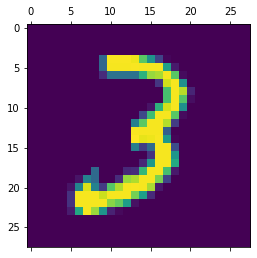

In [36]:
plt.matshow(x_attack_test[15])

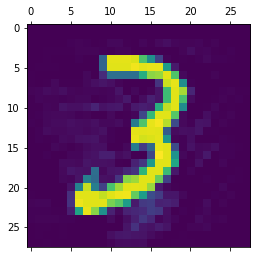

In [37]:
plt.matshow(test_attack[15])

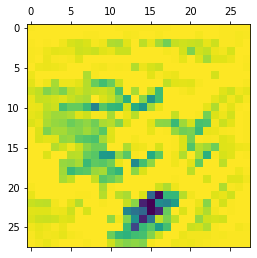

In [39]:
plt.matshow(x_attack_test[15]-test_attack[15])